###  ISIS Ionogram Trace Reading

The following code combines previously made work from the Alouette extraction project into one notebook to find fmin and maxdepth values from an ionogram trace. At the end is a quality analysis for each ionogram. 

**Trace**: Throughout this notebook, "trace" will be used to refer to the graphs on the ionograms containing the recorded data.

In [1]:
#Import libraries
import sys
import numpy as np
import cv2
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from itertools import chain
import ntpath
import scipy.signal as signal
import traceback
import os

In [14]:
#SD_Path = sub-directory path
SD_PATH = Path = ("C:/Users/spunchiwickrama/Documents/Projects/ISIS_I/Test-Images")
#Folder containing 30 images for testing from L:/DATA/ISIS/ISIS_101300030772/b3_R014207773/B1-35-31 ISIS B D-1097

In [15]:
batch_path = '//SAQCJ3YWVDCP003.csa.space.gc.ca/L-DFS/DATA/ISIS/ISIS_101300030772/'

In [16]:
#Generate 10 random images from random subdirectories

def gen_ran_subdir (subdir_path):
    """" Generates a random subdirectory
    Requires: 
    subdir_path: name of the path for the subdirectory
     L:/DATA/ISIS/ISIS_101300030772/b*/B1* """

    all_subs = glob.glob(subdir_path) #creates a list of all subdirects 
    selected_sub = all_subs[random.randint(0, len(all_subs)-1)] #picks a random one from list
    return (selected_sub)

def gen_ran_img (subdir_path, img):
    """" Generates a random image """

    all_img = glob.glob(subdir_path + img) #creates list of all images

    selected_img = all_img[random.randint(0, len(all_img) - 1)]
    return (selected_img)

def random_images(parent_path):
    """" Generates 10 random images
        from a random subdirectory """
    # super basic way
    dirs = os.listdir(parent_path)
    random_dir = random.choice(dirs)
    subdirs = os.listdir(parent_path + random_dir)
    random_subdir = random.choice(subdirs)
    
    subdir_path = parent_path + random_dir + '/' + random_subdir + '/'
    images = os.listdir(subdir_path)
    image_sample = random.sample(images, 10)
    
    temp_dir = ''.join([parent_path, '../quality_analysis/'])
    for i in image_sample:
        shutil.copy(subdir_path + i, temp_dir)
    return image_sample, temp_dir

#SD_PATH = gen_ran_subdir("L:/DATA/ISIS/ISIS_101300030772/b*/B1*")
#img_path = ((gen_ran_img(gen_ran_subdir("L:/DATA/ISIS/ISIS_101300030772/b*/B1*"),"/*")))
#print ("The subdirectory path is", SD_PATH)
#print ("The image path is", img_path)

In [17]:
#Hardcoded values 
#From scan2data > ionogram_grid_determination > grid_mapping.py found by Marianne during Alouette Project
#For ISIS-1

HZ = [0.1,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,12.0,14.0,16.0,18.0,20.0]
DEFAULT_HZ_COORD = [11,42,72,209,255,293,324,375,414,444,475,507,537,569,616,652,686,723,758,790,822,864]

MEAN_HZ = [0.5*(num + DEFAULT_HZ_COORD[i+1])for i, num in enumerate(DEFAULT_HZ_COORD[:-1])]
UPPER_LIMIT_HZ_COORD =[89] + MEAN_HZ 
LOWER_LIMIT_HZ_COORD = MEAN_HZ + [1510]

KM_DEFAULT_100 = 55
KM_DEFAULT_200 = 110


In [18]:
def record_loss(df, function_name, subdir_location, columns_to_extract=None, loss_extraction=None):
    """Generate a dataframe that records loss due to a self-imposed filter or a runtime programming error
    
    :param df: dataframe containing information of which image files did not pass a self-imposed filter or lead to runtime programming errors
    :type df: class: `pandas.core.frame.DataFrame`
    :param function_name: function or self-imposed filter leading to a loss
    :type function_name: str
    :param subdir_location: full path of the subdir
    :type subdir_location: str
    :param columns_to_extract: list of columns of df to extract, defaults to ['file_name']
    :type columns_to_extract: list, optional
    :param loss_extraction: whether a custom series is to be used to extract selected rows from the dataframe, defaults to []
    :type loss_extraction: class: `pandas.core.series.Series`, optional
    :returns: df_loss_extraction,loss_extraction i.e. dataframe containing file names leading to runtime errors or that do not pass pre-established filters (metadata size, ionogram size) as well as boolean series indicating which row of data to remove (==1)
    :rtype: (class: `pandas.core.frame.DataFrame`,class: `pandas.core.series.Series`)
    """   
    if columns_to_extract is None:
        columns_to_extract = ['file_name']
    if loss_extraction is None:
        loss_extraction = []
    if len(loss_extraction) == 0:
        # function should return NA if there an error
        loss_extraction = df.isna().any(axis=1)
    # Record the files whose extraction was not successful
    df_loss_extraction = df[loss_extraction].copy()
    df_loss_extraction = df_loss_extraction[columns_to_extract]
    df_loss_extraction['func_name'] = function_name
    df_loss_extraction['subdir_name'] = subdir_location

    return df_loss_extraction,loss_extraction

In [19]:
#All from scan2data > ionogram_grid_determination > grid_mapping
def all_stack(df_img):
    """Returns the equally weighed sum of all the correctly extracted ionogram plot areas in a subsubdirectory 
    
    :param df_img: Dataframe contaning all the correctly extracted ionogram plot areas in a subsubdirectory (output of image_segmentation.segment_images_in_subdir.segment_images)
    :type df_img: class: `pandas.core.frame.DataFrame`
    :param cutoff_width: the width of an ionogram should be within cutoff_width of the median width of all the ionogram in a subdirectory (should be the same as the one used in scan2data.image_segmentation.segment_images_in_subdir.segment_images)
    :type cutoff_width: int
    :param cutoff_height: the height of an ionogram should be within cutoff_height of the median height of all the ionogram in a subdirectory (should be the same as the one used in scan2data.image_segmentation.segment_images_in_subdir.segment_images)
    :type cutoff_height: int
    :returns: weighed_sum i.e. equally weighed sum of all the extracted ionogram plot areas in a subsubdirectory
    :rtype: class: `numpy.ndarray`
    """
    
    # Pad the image if needed
    max_h = df_img["height"].max()
    max_w =  df_img["width"].max()
    median_h = int(np.median(df_img["height"]))
    median_w = int(np.median(df_img["width"]))
    

    df_img["padded"] = df_img["ionogram"].apply(lambda img: np.pad( img, ((0,max_h- (np.shape(img))[0]),(0,max_w - np.shape(img)[1])),mode="constant",constant_values=1))
    
    weight = len(df_img.index)
    weighed_sum = weight * np.sum((df_img["padded"]).tolist(), axis = 0)
    median_h = median_h if max_h>median_h else median_h-1

    return weighed_sum[0:-(max_h-median_h),0:-(max_w-median_w)]


def indices_highest_peaks(img, row_or_col,
                      peak_prominence_threshold=0.1, distance_between_peaks=5):
    """Determines and returns the indices of peak median values from the rows or column of an image
    
    :param img: grayscale image in the form of an 2D uint8 array
    :type img: class: `numpy.ndarray`
    :param row_or_col: 0 for colum or 1 for row
    :type row_or_col: int
    :param peak_prominence_threshold: the threshold to detect peaks that correspond to the grid lines, defaults to 0.1
    :type peak_prominence_threshold: int, optional
    :param distance_between_peaks: the minimum number of samples between subsequent peaks, defaults to 5
    :type distance_between_peaks: int, optional
    :returns: select_peaks i.e. array of the indices of peak median values from the rows or column of an image
    :rtype: class: `numpy.ndarray`
    """
    
    # Median values along each row or column
    median_values = np.median(img,row_or_col)

    # Normalize median values so they are between 0 and 1
    median_values_normalized = (median_values - np.min(median_values))/(np.max(median_values)-np.min(median_values))

    # Prepare peaks for peak detection function: the peaks should be pointing upwards
    peaks_function = 1 + -1*median_values_normalized 

    # Detect all peaks
    select_peaks, _ = signal.find_peaks(peaks_function, distance=distance_between_peaks, prominence=peak_prominence_threshold) #from scipy.signal

    #Remove edges from peaks
    h,w = np.shape(img)
    select_peaks = select_peaks[:w] if row_or_col == 0 else select_peaks[:h]
    return select_peaks
    

def adjust_arr_peaks(weighed_sum,arr_peaks,desired_length,row_or_col,
                  distance_between_peaks=30,peak_prominence_threshold=0.1,n_tries=1000,update_amount=0.01):
    """Adjust an array of peaks to the desired length and returns it. 
    
     :param weighed_sum: equally weighed sum of all the image plot areas in a subsubdirectory 
     :type weighed_sum: class: `numpy.ndarray`
     :param arr_peaks: array of peaks to adjust to the desired length
     :type arr_peaks: class: `numpy.ndarray`
     :param desired_length: number of elements desired in array
     :type desired_length: int
     :param row_or_col: 0 for colum or 1 for row
     :type row_or_col: int
     :param distance_between_peaks: the minimum number of samples between subsequent peaks, defaults to 30
     :type distance_between_peaks: int, optional
     :param peak_prominence_threshold: the threshold to detect peaks that correspond to the grid lines, defaults to 0.1
     :type peak_prominence_threshold: int, optional
     :param n_tries: the number of maximum tries to adjust arr, defaults to 1000
     :type n_tries: int, optional
     :param update_amount: by how much peak_prominence_threshold is updated for each iteration, defaults to 0.01
     :type update_amount: int, optional
     :returns: select_peaks i.e. adjusted array of the indices of peak median values from the rows or column of an image
     :rtype: class: `numpy.ndarray`
     ..note:: To prevent infinite loops, the script only runs for a maximum of n_tries times
    """
    
    arr_peaks = indices_highest_peaks(weighed_sum, row_or_col, peak_prominence_threshold, distance_between_peaks)  

    # Adjust if lenght is not the desired length by re-running indices_highest_peaks with different parameters
    while len(arr_peaks) != desired_length and n_tries !=0:
        
        if len(arr_peaks) > desired_length:
            # increase peak_prominence_threshold 
            peak_prominence_threshold = peak_prominence_threshold + update_amount
        else:
            # decrease peak_prominence_threshold
            peak_prominence_threshold = peak_prominence_threshold - update_amount
        arr_peaks = indices_highest_peaks(weighed_sum, row_or_col, peak_prominence_threshold, distance_between_peaks)
        n_tries = n_tries - 1


    return arr_peaks


def get_grid_mappings(weighed_sum, use_defaults=True, min_index_row_peaks=40):
    """Determines and returns the the mapping between coordinate values and frequency/depth values in a subdirectory
    
    :param weighed_sum: equally weighed sum of all the image plot areas in a subsubdirectory 
    :type weighed_sum: class: `numpy.ndarray`
    :param use_defaults: use default values , defaults to True
    :type use_defaults: bool
    :param min_index_row_peaks: starting index to consider for peaks to determine km lines,defaults to 40
    :type min_index_row_peaks: int, optional
    :returns:  col_peaks,row_peaks,mapping_Hz, mapping_km i.e. one-dimmensional array of detected peaks of ionogram by column, one-dimmensional array of detected  peaks of by row, dictionary mapping of depth (km) to y coordinates  , dictionary mapping of frequency (Hz) to x coordinates
    :rtype: class: `numpy.ndarray`,class: `numpy.ndarray`,class: `dict`, class: `dict`
    :raises Exception: returns np.nan,np.nan,np.nan,np.nan
    """
    # Detect peaks
    col_peaks = indices_highest_peaks(weighed_sum, 0)
    row_peaks = indices_highest_peaks(weighed_sum, 1)

    # Map col_peaks to Hz values
    if len(col_peaks) == len(HZ):
        mapping_Hz = dict(zip(HZ,col_peaks)) 

    else:
        try:
            col_peaks = adjust_arr_peaks(weighed_sum, col_peaks, len(HZ), 0)
            mapping_Hz = dict(zip(HZ,col_peaks)) 

            # Map adjusted HZ values to default coordinates if need be
            if use_defaults:
                for i,key in enumerate(HZ):
                    if mapping_Hz[key] > UPPER_LIMIT_HZ_COORD[i] or mapping_Hz[key] < LOWER_LIMIT_HZ_COORD[i]:
                        mapping_Hz[key] = DEFAULT_HZ_COORD[i]
        except Exception:
            if use_defaults:
                 mapping_Hz = dict(zip(HZ,DEFAULT_HZ_COORD)) 
            else:    
                return np.nan,np.nan,np.nan,np.nan


    row_peaks = row_peaks[row_peaks > min_index_row_peaks]

    try:
        row_100 = row_peaks[0] #Should be around 30 for 100 km
        row_200 = row_peaks[1] #Should be around 30 for 100 km
        # comments pressumably for Alouette - 20231129
    except Exception:
        if not use_defaults:
            return np.nan,np.nan,np.nan,np.nan

        row_100 = KM_DEFAULT_100
        row_200 = KM_DEFAULT_200
    if use_defaults:
        if abs(row_100 - KM_DEFAULT_100) > abs(KM_DEFAULT_200 - KM_DEFAULT_100):
            row_100 = KM_DEFAULT_100
        if abs(row_200 - KM_DEFAULT_200) > abs(KM_DEFAULT_200 - KM_DEFAULT_100):
            row_200 = KM_DEFAULT_200   

    mapping_km = {100:row_100,200:row_200}

    return col_peaks, row_peaks, mapping_Hz, mapping_km

In [20]:
#From scan2data > ionogram_content_extraction > extract_all_coordinates_ionogram_trace.py
def extract_ionogram_windows(binary_iono, stepSize=25, windowSize=(100, 100)):
    """Clean ionogram by using small thresholding windows

    :param binary_iono: two-dimmensional uint8 array representing ionogram where the extracted threshold values are in while (1s) while the rest is in black (0s)
    :type binary_iono: class: `numpy.ndarray`
    :param stepSize: By how much window moves to the right and/or bottom
    :type stepSize: int
    :param windowSize: (height, width) of moving window
    :type windowSize: tuple
    :returns new_iono: cleaned ionogram represented by  two-dimmensional uint8 array
    :rtype:  class: `numpy.ndarray`

    """
    # TODOs: impove thresholding for windowing
    threshold = np.mean(binary_iono) * 2

    h_iono, w_iono = np.shape(binary_iono)
    h_window, w_window = windowSize
    new_iono = np.zeros((h_iono, w_iono))

    for y in range(0, h_iono - h_window, stepSize):
        for x in range(0, w_iono - w_window, stepSize):
            box = binary_iono[y:y + h_window, x:x + w_window]
            if np.mean(box) > threshold:
                new_iono[y:y + h_window, x:x + w_window] = box

    return new_iono

#From scan2data > ionogram_content_extraction > extract_select_parameters.py
def extract_fmin_and_max_depth(arr_adjusted_coord, min_depth=50, if_raw=False):
    """Extract the minimum detected frequency value and maximum detected depth
    
    :param arr_raw_coord:  one-dimmensional array of values of all the pixels corresponding to the ionogram trace
    :type arr_raw_coord: class: `numpy.ndarray`
    :param min_depth: minimum depth in km to be considered, defaults to 30
    :type min_depth: int, optional
    :param if_raw: if (x,y) rather than (Hz,km) coordinates are used, defaults to False
    :type if_raw: bool, optional
    :returns: fmin, depth_max i.e. minimum frequency detected and maximum depth detected
    :rtype: float, float
    :raises Exception: returns np.nan, np.nan
    
    """
    try:
        adjusted_x, adjusted_y = zip(*arr_adjusted_coord)
        adjusted_x = np.array(adjusted_x)
        adjusted_y = np.array(adjusted_y)

        if if_raw:
            min_depth= int(min_depth * KM_DEFAULT_100/100)

        thresholded = adjusted_y > min_depth
        adjusted_x_thresholded = adjusted_x[thresholded]
        adjusted_y_thresholded = adjusted_y[thresholded]

        fmin = min(adjusted_x_thresholded)
        depth_max =  max(adjusted_y_thresholded)
        return fmin, depth_max
    except Exception:
        return np.nan, np.nan

#From scan2data > ionogram_content_extraction > extract_all_coordinates_ionogram_trace.py   
def extract_coord(iono, col_peaks, row_peaks,
                  threshold=200, kernel_size_blurring=5):
    """Extract (x,y) of all the pixels corresponding to the ionogram trace

    :param iono: two-dimmensional uint8 array representing raw ionogram
    :type iono: class: `numpy.ndarray`
    :param col_peaks: one-dimmensional array of detected peaks of ionogram by column
    :type col_peaks: class: `numpy.ndarray`
    :param row_peak: one-dimmensional array of detected  peaks of by row
    :type row_peaks: class: `numpy.ndarray`
    :param threshold: threshold of inverted pixel value to be considered ionogram data, defaults to 200
    :type threshold: int, optional
    :param kernel_size_blurring: kernel size for median filtering operation, defaults to 5
    :type kernel_size_blurring: int, optional
    :returns: arr_raw_coord0 ,arr_raw_coord: one-dimmensional array of (x,y) coordinates of all the pixels corresponding to the ionogram trace
    :rtype: class: `numpy.ndarray`,class: `numpy.ndarray`
    :raises Exception: returns np.nan,np.nan if there is an error

    """
    
    # Shape of image
    try:
        h, w = np.shape(iono)

        # Median blurring to remove salt and pepper noise
        median_filtered_iono = cv2.medianBlur(iono, kernel_size_blurring)

        # Invert image
        inverted_iono = 255 - median_filtered_iono

        # Correct image for grid ie remove the grid
        grid = np.ones((h, w), np.uint8)
        for i in col_peaks:
            cv2.line(grid, (i, 0), (i, h), 0, 5, 1)
        for i in row_peaks:
            cv2.line(grid, (0, i), (w, i), 0, 5, 1)
        corrected_iono = np.multiply(grid, inverted_iono)

        # Assuming trace is going to be black ie mostly values close to 0 in the array
        # Thus, the inverted trace is going to be white ie values most close to 252
        # Threshold the image
        _, thresholded_iono = cv2.threshold(corrected_iono, threshold, 1, cv2.THRESH_BINARY)

        # Corrected ionogram by windowing operations
        windowed = extract_ionogram_windows(thresholded_iono)

        # y and x coordinates
        arr_y, arr_x = np.where(thresholded_iono == 1)
        arr_raw_coord0 = np.array(list(zip(arr_x, arr_y)), dtype=np.float64)

        arr_y, arr_x = np.where(windowed == 1)
        arr_raw_coord = np.array(list(zip(arr_x, arr_y)), dtype=np.float64)

        return arr_raw_coord0, arr_raw_coord  # raw_coord, windowed_coord    `
    except Exception:
        return np.nan, np.nan

#From scan2data > ionogram_content_extraction > extract_all_coordinates_ionogram_trace.py
def map_coordinates_positions_to_values(arr_raw_coord, col_peaks, row_peaks, mapping_Hz, mapping_km):
    """Map (x,y) position coordinates of ionogram pixels to (Hz,km) values

    :param arr_raw_coord:  one-dimmensional array of (x,y) coordinates of all the pixels corresponding to the ionogram trace
    :type arr_raw_coord: class: `numpy.ndarray
    :param col_peaks: one-dimmensional array of detected peaks of ionogram by column
    :type col_peaks: class: `numpy.ndarray`
    :param row_peak: one-dimmensional array of detected  peaks of by row
    :type row_peaks: class: `numpy.ndarray`
    :param mapping_Hz: dictionary mapping of frequency (Hz) to x coordinates
    :type mapping_Hz: class: `dict`
    :param mapping_km:  dictionary mapping of depth (km) to y coordinates
    :type mapping_km: class: `dict`
    :returns: arr_adjusted_coord: one-dimmensional array of (Hz,km) values of all the pixels corresponding to the ionogram trace
    :rtype: class: `numpy.ndarray`
    """

    # check if there are any coordinate values recorded for the ionogram
    if len(arr_raw_coord)==0:
        return arr_raw_coord

    # remove outliers ie coordinates less coordinates corresponding to 0.5 Hz or more than corresponding to 11.5 Hz
    col_peaks = np.array(list(mapping_Hz.values()))  # use the modified col_peaks ie the one with exactly 13 values

    mask = np.logical_or(arr_raw_coord[:, 0] < col_peaks.min(), arr_raw_coord[:, 0] > col_peaks.max())
    arr_raw_coord = arr_raw_coord[~mask, :]

    # map (y,x) to (km, Hz)
    km_values, index_values_km = list(zip(*list(mapping_km.items())))
    multiplier = (km_values[1] - km_values[0]) / (index_values_km[1] - index_values_km[0])

    arr_adjusted_coord = arr_raw_coord.copy()
    arr_adjusted_coord[:, 1] = km_values[0] + (arr_adjusted_coord[:, 1] - index_values_km[0]) * multiplier

    # reverse mapping_km mappings
    mapping_Hz_reversed = {mapping_Hz[freq_key]: freq_key for freq_key in mapping_Hz}
    arr_adjusted_x = np.array([])
    for coord_x in arr_adjusted_coord[:, 0]:
        if coord_x in col_peaks:
            new_coord_x = mapping_Hz_reversed[coord_x]
        else:
            # find the 2 closest values and linearly interpolate from there
            leftmost_val = col_peaks[col_peaks < coord_x].max()
            rightmost_val = col_peaks[col_peaks > coord_x].min()
            multiplier = (mapping_Hz_reversed[rightmost_val] - mapping_Hz_reversed[leftmost_val]) / (
                        rightmost_val - leftmost_val)
            new_coord_x = mapping_Hz_reversed[leftmost_val] + multiplier * (coord_x - leftmost_val)

        arr_adjusted_x = np.append(arr_adjusted_x, new_coord_x)
    arr_adjusted_coord[:, 0] = arr_adjusted_x

    return arr_adjusted_coord

#From scan2data > ionogram_content_extraction > extract_all_coordinates_ionogram_trace.py
def extract_coord_subdir_and_param(df_img, subdir_location, col_peaks, row_peaks, mapping_Hz, mapping_km):
    """Extract the raw, windowed coordinates in all the raw extracted ionograms from a subdirectory, map those coordinates into (Hz, km) and extract select parameterd

    :param df_img: Dataframe containing all the correctly extracted ionogram plot areas in a subsubdirectory (output of image_segmentation.segment_images_in_subdir.segment_images)
    :type df_img: class: `pandas.core.frame.DataFrame`
    :param subdir_location: Path of the subdir_location
    :type subdir_location: string
    :param col_peaks: one-dimmensional array of detected peaks of ionogram by column
    :type col_peaks: class: `numpy.ndarray`
    :param row_peak: one-dimmensional array of detected  peaks of by row
    :type row_peaks: class: `numpy.ndarray`
    :param mapping_Hz: dictionary mapping of frequency (Hz) to x coordinates
    :type mapping_Hz: class: `dict`
    :param mapping_km:  dictionary mapping of depth (km) to y coordinates
    :type mapping_km: class: `dict`
    :returns: df_img, df_loss: i.e.  i.e. dataframe containing extracted ionogram trace coordinates from all the extracted raw ionograms in a directory,dataframe containing file names leading to runtime errors
    :rtype: class: `pandas.core.frame.DataFrame`, class: `pandas.core.frame.DataFrame`

    """
    # Get (x,y) coordinates of trace
    if(len(df_img)==1):
        c1, c2 = zip(*df_img['ionogram'].map(lambda iono: extract_coord(iono, col_peaks, row_peaks)))
        df_img['raw_coord'] = list(c1)
        df_img['window_coord'] = list(c2)
        
    else :
        df_img['raw_coord'], df_img['window_coord'] = zip(
            *df_img['ionogram'].map(lambda iono: extract_coord(iono, col_peaks, row_peaks)))

    # Remove loss
    df_loss_coord, loss_coord = record_loss(df_img,
                                            'ionogram_content_extraction.extract_all_coordinates_ionogram_trace.extract_coord_subdir',
                                            subdir_location) #from helper functions.py
    df_img = df_img[~loss_coord]

    #df_img.to_csv("U:/alouette-scanned-ionograms-processing/df_img.csv", index=False)

    # (Hz, km) coordinates
    df_img['mapped_coord'] = df_img['window_coord'].map(
        lambda windowed: map_coordinates_positions_to_values(windowed, col_peaks, row_peaks, mapping_Hz, mapping_km))

    # Select parameters extracted
    #df_mapped_temp = df_img['mapped_coord'].map(lambda mapped_coord: extract_fmin_and_max_depth(mapped_coord))) #from extract_select_parameters.py  #Q: I wonder if f_min and depth_max is actually scientifically useful? Why don't we extract mapped_coord instead?
    df_mapped_temp = df_img.apply(lambda row: extract_fmin_and_max_depth(row['mapped_coord']), axis = 1, result_type = "expand")
    df_img = df_img.assign(fmin = df_mapped_temp[0])
    df_img = df_img.assign(max_depth = df_mapped_temp[1])

    # Remove loss.
    df_loss_param, loss_param = record_loss(df_img,
                                            'ionogram_content_extraction.extract_select_parameters.extract_fmin_and_max_depth',
                                            subdir_location)
    df_img = df_img[~loss_param]

    df_loss = pd.concat([df_loss_coord, df_loss_param])

    return df_img, df_loss

#From scan2data > image_segmentation > extract_ionogram_from_scan.py
def limits_ionogram(raw_img, row_or_col, starting_index_col=15):
    """Returns the upper and lower limits of the ionogram part of the scan by row or column using mean-based thresholding
    
    :param starting_img: UTF-8 grayscale 2D array of values ranging from [0,255] representing raw scanned image
    :type starting_img: class: `numpy.ndarray`
    :param row_or_col: 0 for column or 1 for row
    :type row_or_col: int
    :param starting_index_col: where the ionogram starting column should be after to protect against cuts, defaults to 15
    :type starting_index_col: int, optional
    :return:  limits[0],limits[-1] i.e. the upper and lower limits of the ionogram part of the scan by row (row_or_col=1) or column (row_or_col=0)
    :rtype: int,int
            
            
    """
    
    # Mean pixel values by by row/col
    mean_values = np.mean(raw_img, row_or_col)
    
    # Normalized mean values
    normalized_mean_values = (mean_values - np.min(mean_values))/np.max(mean_values)
    
    # Threshold is the overall mean value of the entire image
    threshold = np.mean(normalized_mean_values)
    
    if row_or_col == 0:
        #Protect against scans that includes cuts from another ionogram ex:R014207956\2394-1B\51.png 
        limits = [i for i, mean in enumerate(normalized_mean_values) if mean >threshold and i > starting_index_col]
    else:
        limits = [i for i, mean in enumerate(normalized_mean_values) if mean >threshold]
        
    return limits[0], limits[-1]

#From scan2data > image_segmentation > extract_ionogram_from_scan.py
def extract_ionogram(raw_img_array):
    """Extract ionogram part of a raw scanned image and return coordinates delimiting its limits
    
    :param raw_img_array: UTF-8 grayscale 2D array of values ranging from [0,255] representing raw scanned image
    :type raw_img_array: class: `numpy.ndarray`
    :return: (limits, ionogram) i.e. (list of coordinates delimiting the limits of the ionogram part of a raw scanned image formatted as [x_axis_left_limit ,x_axis_right_limit, y_axis_upper_limit, y_axis_lower_limit], UTF-8 grayscale 2D array of values ranging from [0,255] representing ionogram part of scanned image)
    :rtype: (list,numpy.ndarray)
    :raises Exception: returns [],np.nan if there is an error
        
    """
    try:
        # Extract coordinate delimiting the ionogram part of the scan
        x_axis_left_limit ,x_axis_right_limit = limits_ionogram(raw_img_array, 0)
        y_axis_upper_limit, y_axis_lower_limit = limits_ionogram(raw_img_array, 1)

        # Extract ionogram part
        ionogram = raw_img_array[y_axis_upper_limit:y_axis_lower_limit,x_axis_left_limit:x_axis_right_limit]

        #Just added for checking the metadata part of image
        #imgMetadataPart = raw_img_array[y_axis_upper_limit:y_axis_lower_limit, 15:x_axis_left_limit - 1]
        #cv2.imshow("test Metadata", imgMetadataPart)
        #cv2.waitKey(0)

        limits = [x_axis_left_limit ,x_axis_right_limit, y_axis_upper_limit, y_axis_lower_limit]
        return (limits, ionogram)

    except Exception:
        return ([],np.nan)

In [21]:
### PROCESSING
# scan2data > image_segmentation > segment_images_in_subdir
def segment_images(subdir_location, regex_img,
                  cutoff_width = 300, cutoff_height=150,
                  min_leftside_meta_width = 50, min_bottomside_meta_height=15): #min_bottomside_meta_height=25
    """From all the raw images in a subsubdirectory, extract the ionogram and trimmed metadata while handling errors and recording loss of data
    
    :param subdir_location: full path of the subdir
    :type subdir_location: str
    :param regex_img: regular expression to extract image
    :type regex_img: str
    :param cutoff_width: the width of an ionogram should be within cutoff_width of the median width of all the ionogram in a subdirectory, defaults to 300
    :type cutoff_width: int, optional
    :param cutoff_height: the height of an ionogram should be within cutoff_height of the median height of all the ionogram in a subdirectory, defaults to 150
    :type cutoff_height: int, optional
    :param min_leftside_meta_width: the minimum width of trimmed metadata located on the left side of ionograms, defaults to 50
    :type min_leftside_meta_width: int, optional
    :param min_bottomside_meta_height: the minimum height of trimmed metadata located on the bottom side of ionograms, defaults to 25
    :type min_bottomside_meta_height: int, optional
    :return: df_img,df_loss,df_outlier i.e. dataframe containing extracted ionograms and trimmed metadata from all the images in a directory,dataframe containing file names leading to runtime errors, dataframe containing file names that do not pass pre-established filters (metadata size, ionogram size)
    :rtype: (class: `pandas.core.frame.DataFrame`,class: `pandas.core.frame.DataFrame`,class: `pandas.core.frame.DataFrame`)
    .. todo:: complete flip_vertical ie list of subdirectories requiring flipping
    """
    # List of raw image files in subdirectory
    regex_raw_image = subdir_location + regex_img

    list_images = glob.glob(regex_raw_image)

    # DataFrame for processing
    df_img = pd.DataFrame(data = {'file_name': list_images})     

    #Read each image in an 2D UTF-8 grayscale array
    df_img['raw'] = df_img['file_name'].map(lambda file_name: cv2.imread(file_name,0))
    
    # Extract ionogram and coordinates delimiting its limits
    #extract_ionogram is being imported 
    df_img['limits'], df_img['ionogram'] = zip(*df_img['raw'].map(lambda raw_img: extract_ionogram(raw_img))) #from extract_ionogram_from_scan.py

    # Record the files whose ionogram extraction was not successful
    df_loss_ion_extraction, loss_ion_extraction = record_loss(df_img,'image_segmentation.extract_ionogram_from_scan.extract_ionogram',subdir_location)

    # Remove files whose ionogram extraction was not successful
    df_img = df_img[~loss_ion_extraction]

    # Extract the shape of each ionogram in subdirectory
    df_img['height'],df_img['width'] = zip(*df_img['ionogram'].map(lambda array_pixels: array_pixels.shape))

    #Find median height and width of ionogram in subdirectory
    median_height = np.median(df_img['height'])
    median_width = np.median(df_img['width'])

    # Find and remove ionogram outliers    
    conditional_list_ionogram = [abs(df_img['height'] -median_height) > cutoff_height,abs(df_img['width'] - median_width) > cutoff_width]
    outlier_ionogram = np.any(conditional_list_ionogram,axis = 0)

    df_outlier_ionogram,_ = record_loss(df_img,'image_segmentation.segment_images_in_subdir.segment_images: iono size outlier',subdir_location,['file_name','height','width'],outlier_ionogram)

    # Log outlier
    if not df_outlier_ionogram.empty:
        df_outlier_ionogram[ 'details'] = df_outlier_ionogram.apply(lambda row: 'height: ' + str(row['height'])+',width: ' + str(row['width']), 1)
        df_outlier_ionogram = df_outlier_ionogram[['file_name','func_name','subdir_name','details']]
    else:
        df_outlier_ionogram = df_outlier_ionogram[['file_name','func_name','subdir_name']]

    # Remove outlier
    df_img = df_img[~outlier_ionogram]

    # Dataframe recording loss from programming errors
    df_loss = pd.concat([df_loss_ion_extraction])

    # Dataframe recording loss from various filters i.e. metadata too small, ionogram too small/big
    df_outlier = pd.concat([df_outlier_ionogram]) #df_outlier_metadata_location

    return df_img, df_loss, df_outlier

#From scan2data > process_directory
def process_subdirectory(subdir_path, regex_images):
    """Transform raw scanned images in a subdirectory into information

    :param subdir_path: path of subdir_path
    :type subdir_path: str
    :param regex_img: regular expression to extract images ex: '*.png'
    :type regex_img: str
    :param output_folder_if_pickle: output folder for pickle, use None if no pickle
    :type output_folder_if_pickle: string
    :param min_n_leftside_metadata: minimum number of ionograms with metadata on the left to be able to call metadata_translation.leftside_metadata_grid_mapping, defaults to 10
    :type min_n_leftside_metadata: int, optional
    :returns: df_processed, df_loss, df_outlier: :  dataframe containing data from running the full processing pipeline,dataframe containing file names leading to runtime errors, dataframe containing file names that do not pass pre-established filters (metadata size, ionogram size)
    :rtype: class: `pandas.core.frame.DataFrame`,class: `pandas.core.frame.DataFrame`,class: `pandas.core.frame.DataFrame`
    """
    # Run segment_images on the subdirectory
    df_img, df_loss, df_outlier = segment_images(subdir_path, regex_images) #from image_segmentation.segment_images_in_subdir.py

    # Determine ionogram grid mappings used to map (x,y) pixel coordinates of ionogram trace to (Hz, km) values
    stack = all_stack(df_img) #from grid_mapping.py

    col_peaks, row_peaks, mapping_Hz, mapping_km = get_grid_mappings(stack) #from grid_mapping
            
    df_processed_bottom, df_loss_coord_bottom = extract_coord_subdir_and_param(df_img, subdir_path, col_peaks, row_peaks, mapping_Hz, mapping_km) #from ionogram_content_extraction.extract_all_coordinates_ionogram_trace

    #Recombine left and bottom-side metadata images
    df_processed = pd.concat([df_processed_bottom])
    df_loss_coord = pd.concat([df_loss_coord_bottom])

    df_processed['mapping_Hz'] = [mapping_Hz] * len(df_processed.index)
    df_processed['mapping_km'] = [mapping_km] * len(df_processed.index)

    df_loss = pd.concat([df_loss, df_loss_coord])
    #df_processed.to_csv((f"{output_path}iono-processed.csv"))
    df_processed.to_csv("C:/Users/spunchiwickrama/Documents/Projects/ISIS_I/iono-processed-20231213.csv")
    
    return df_processed, df_loss, df_outlier

### QA: Inspect Extracted Ionogram Points
A typical ionogram will be scaled as seen in the figure below.  

Source: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2011RS004963  \
^ some figures include images from ISIS-2 but should be applicable to ISIS-1


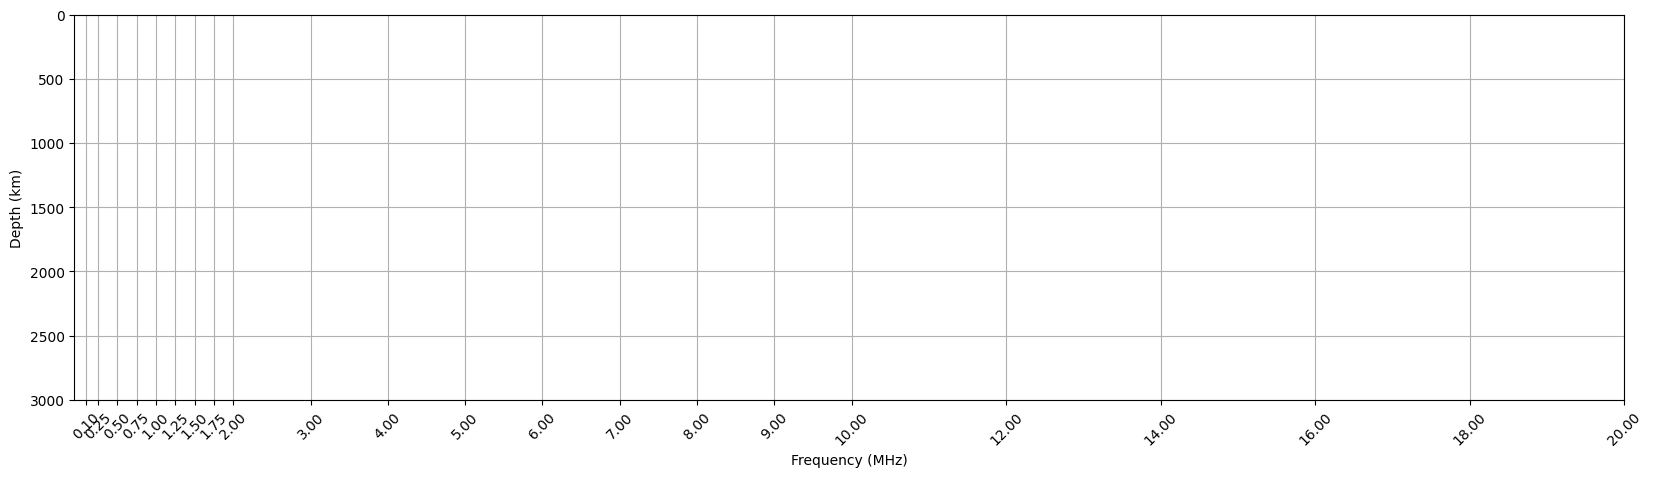

In [22]:
x_vals = HZ
y_vals = [3000, 2500, 2000, 1500, 1000, 500, 0]

plt.figure(figsize=(20, 5))
plt.gca().invert_yaxis()
plt.plot()
plt.grid(True)
plt.xticks(x_vals, rotation = 45)
plt.xlabel("Frequency (MHz)")
plt.yticks(y_vals)
plt.ylabel("Depth (km)")
plt.show()

In [23]:
# this just shows how to do this for one sample of 10 images,
# need to iterate over it + save subdir info for full solution
#image_sample, temp_dir = random_images(batch_path)

File name C:/Users/spunchiwickrama/Documents/Projects/ISIS_I/Test-Images\Image0028.png
(2999, 2)
[[   0.8423913  -173.33333333]
 [   0.84782609 -173.33333333]
 [   0.85326087 -173.33333333]
 ...
 [   1.11842105  760.        ]
 [   1.125       760.        ]
 [   1.13157895  760.        ]]


[[], []]

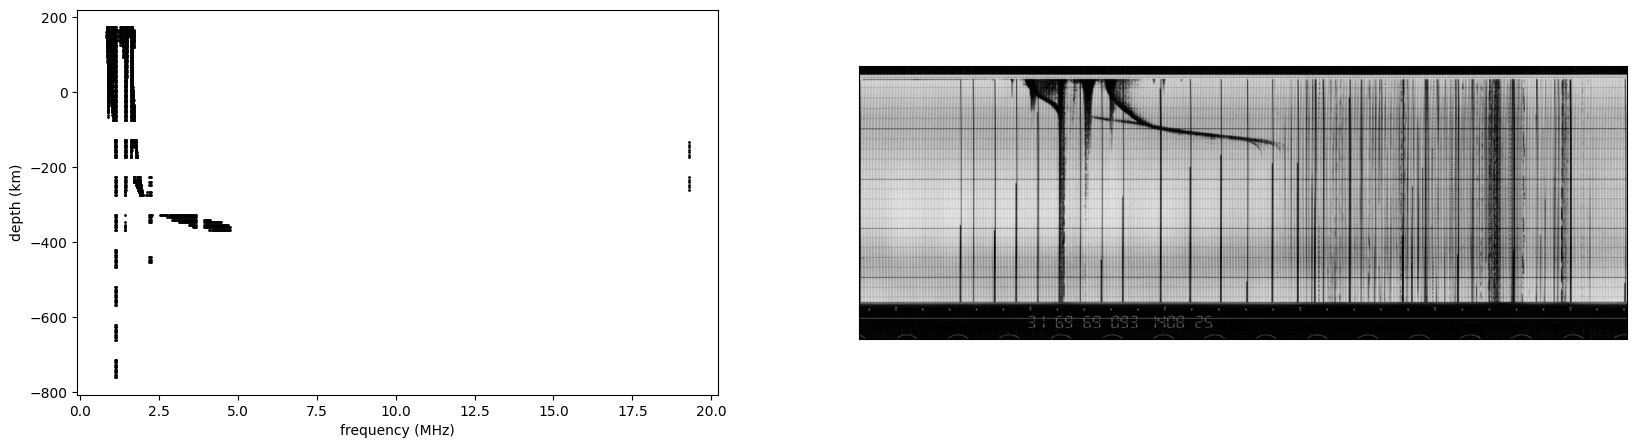

In [25]:
## inspect extracted points
#SD_PATH = temp_dir
      
## inspect extracted points
#df = (process_subdirectory(SD_PATH, "/*", temp_dir))[0]
df = (process_subdirectory(SD_PATH, "/*"))[0]
df.index = range(len(df.index))

#Pick random image from processed images
#For a specifi file, replace with file path
df_sample = (df['file_name'])[random.randint(0, len(df["file_name"]) - 1)]
print ("File name", df_sample)

#Find position of file in dataframe and extract mapped coords array
pos = df[df['file_name'] == df_sample].stack().index.tolist()
arr_load = (df.loc[pos[0][0], 'mapped_coord'])
print(arr_load.shape)
print (arr_load)


df_plot = pd.DataFrame({
    'f': arr_load[:, 0],
    'depth': arr_load[:, 1]
})
df_plot['depth_plot'] = -1*df_plot['depth']
df_plot.head()

f, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1,1.2],}, figsize=(20,5))

axs[0].scatter(df_plot['f'], df_plot['depth_plot'], 1, color='black')
axs[0].set(xlabel='frequency (MHz)', ylabel='depth (km)')

img = mpimg.imread(df_sample)
axs[1].imshow(img)
axs[1].set(xticks=[], yticks=[])

Fmin = 232.0
df sample 0.8804347826086957


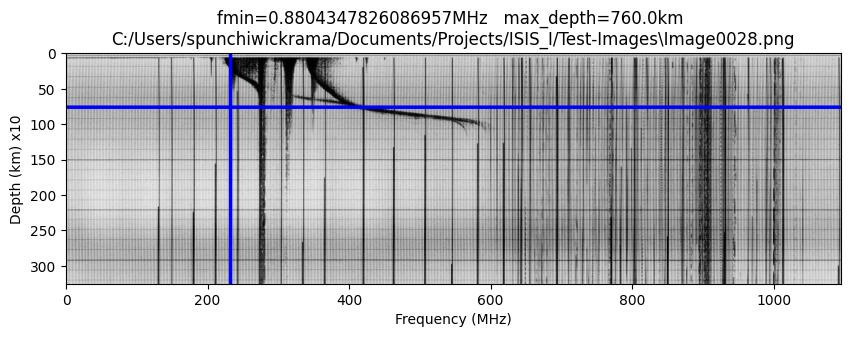

In [32]:
df_sample_ionogram = (df.loc[pos[0][0], 'ionogram'])
df_sample_mappingHz = (df.loc[pos[0][0], 'mapping_Hz'])
df_sample_window = (df.loc[pos[0][0], 'window_coord'])

df_sample_fmin = (df.loc[pos[0][0], 'fmin'])
df_sample_maxdepth = (df.loc[pos[0][0], 'max_depth'])

col_peaks = np.array(list(df_sample_mappingHz.values())) # use the modified col_peaks ie the one with exactly 13 values
mask = np.logical_or(df_sample_window[:,0] < col_peaks.min(), df_sample_window[:,0] > col_peaks.max())
window_coord_adjusted = df_sample_window[~mask,:]

fmin_coord, __ = extract_fmin_and_max_depth(window_coord_adjusted,if_raw=True)

colored_iono = cv2.cvtColor(df_sample_ionogram ,cv2.COLOR_GRAY2RGB)
h,w = np.shape(df_sample_ionogram)
cv2.line(colored_iono,(int(fmin_coord),0),(int(fmin_coord),h),[0,0,255],3)
cv2.line(colored_iono,(0,int(df_sample_maxdepth/10)),(w,int(df_sample_maxdepth/10)),[0,0,255],3)
plt.figure(figsize=(10, 5))
plt.imshow(colored_iono)
plt.title(f'fmin={str(df_sample_fmin)}MHz   max_depth={str(df_sample_maxdepth)}km \n' + df_sample)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Depth (km) x10")
plt.show()

*The frequency ticks on graph are incorrect and need fixing

In [33]:
print("From Ionogram Image: Enter frequency location of maximum depth (x to +/- 0.5 MHz):")
user_freq_max_depth = float(input())
print("you entered:", user_freq_max_depth)

print("From Ionogram Image: Enter maximum depth (y to +/- 50 km):")
user_max_depth = float(input())
print("you entered:", user_max_depth)

From Ionogram Image: Enter frequency location of maximum depth (x to +/- 0.5 MHz):
you entered: 0.0
From Ionogram Image: Enter maximum depth (y to +/- 50 km):
you entered: 0.0
